In [1]:
%matplotlib inline
from scipy import io
from neurodsp import spectral
import os
import datetime
import matplotlib.pyplot as plt
from fooof import FOOOFGroup
from fooof.funcs import fit_fooof_group_3d, combine_fooofs
import numpy as np
from scipy import signal
import sys
import pandas as pd

sys.path.append('../')
import utils

In [381]:
basepath = '/Users/rdgao/Documents/data/CRCNS/fcx1/'
rec_dirs = [f for f in np.sort(os.listdir(basepath)) if os.path.isdir(basepath+f)]
result_basepath = '/Users/rdgao/Documents/code/research/field-echos/results/fcx1/wakesleep/'
[print(i,f) for i,f in enumerate(rec_dirs)];

0 20140526_277um
1 20140527_421um
2 20140528_565um
3 BWRat17_121712
4 BWRat17_121912
5 BWRat18_020513
6 BWRat19_032413
7 BWRat19_032513
8 BWRat20_101013
9 BWRat20_101513
10 BWRat21_121113
11 BWRat21_121613
12 BWRat21_121813
13 Bogey_012615
14 Dino_061814_mPFC
15 Dino_061914_ACC
16 Dino_061914_mPFC
17 Dino_062014_ACC
18 Dino_062014_mPFC
19 Dino_072114_mPFC
20 Dino_072314_mPFC
21 Dino_072414_mPFC
22 Rizzo_022615
23 Rizzo_022715
24 Splinter_020515
25 Splinter_020915
26 Templeton_032415


# Processing

In [452]:
cur_rec = 0
ephys_data = io.loadmat(basepath+rec_dirs[cur_rec]+'/'+rec_dirs[cur_rec]+'_ephys.mat', squeeze_me=True)
behav_data = pd.read_csv(basepath+rec_dirs[cur_rec]+'/'+rec_dirs[cur_rec]+'_wakesleep.csv', index_col=0)
ephys_data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'elec_regions', 'elec_shank_map', 'fs', 'lfp', 'spike_info', 'spike_info_cols', 'spiketrain'])

In [437]:
# this needs to be more clever when handling gigantic spiketrains
def acf_events(spks, t_max, dt=0.001, norm=True, remove_zero=False):
    # get time bins on positive side and reflect around 0
    # lazy way of getting symmetric bin edges
    bins = np.sort(np.concatenate((-np.arange(dt/2,t_max+dt,dt),np.arange(dt/2,t_max+dt,dt))))
    ac_times = []
    for i, spk in enumerate(spks):
        # a little hack: only get the positive side and just reflect to save time
        # this only works for acorr, not xcorr
        del_t = spks[i:]-spk
        ac_times.append(del_t[np.abs(del_t)<=t_max])

    ac_times = np.concatenate(ac_times)    
    if remove_zero:
        ac_times = ac_times[ac_times!=0]
    ac, t_ac = np.histogram(ac_times, bins=bins)

    # fill the negative side
    ac[:int(np.floor(len(ac)/2))] = ac[-int(np.floor(len(ac)/2)):][::-1]
    t_ac = t_ac[1:]-dt/2
    # normalize by total spike count
    if norm: ac = ac/len(spks)
    return t_ac, ac

In [638]:
# individual cells
t_max, dt = 2., 0.005

spike_segs = np.append(np.array([0]),ephys_data['spike_info'][:,4])
behav_sub = behav_data[behav_data['Label'].isin(['Wake', 'Sleep'])].reset_index()
ac_all = np.zeros((len(behav_sub), len(spike_segs)-1, int(2*t_max/dt)+1))

for cell in range(len(spike_segs)-1):
    print(cell,end='|')
    spks = ephys_data['spiketrain'][spike_segs[cell]:spike_segs[cell+1]]
    for ind, cur_eps in behav_sub.iterrows():
        spks_eps = spks[np.logical_and(spks>=cur_eps['Start'],spks<cur_eps['End'])]
        t_ac, ac_all[ind, cell,:] = acf_events(spks_eps, t_max, dt, norm=True)

f_ac = np.fft.fftfreq(ac_all.shape[-1], dt)
psd = np.abs(np.fft.fft(ac_all*signal.hann(ac_all.shape[-1])[None,None,:]))

0|1|2|3|4|5|6|7|8|9|10|11|12|13|14|15|16|17|18|19|20|21|22|23|24|25|26|27|28|29|30|31|32|33|34|35|36|37|38|39|40|41|42|43|44|45|46|47|48|49|50|51|52|53|54|55|56|57|58|59|60|61|

In [647]:
# population of E, I, and all cells
#ephys_data['spike_info']

In [648]:
spks = np.sort(ephys_data['spiketrain'])
ac_pop = np.zeros((len(behav_sub), 3, int(2*t_max/dt)+1))
for ind, cur_eps in behav_sub.iterrows():
    spks_eps = spks[np.logical_and(spks>=cur_eps['Start'],spks<cur_eps['End'])]
    t_ac, ac_pop[ind,0,:] = acf_events(spks_eps, t_max, dt, norm=True)


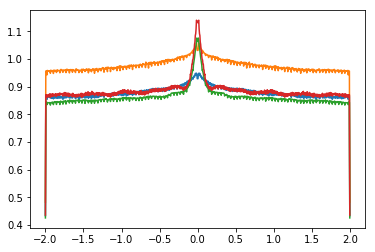

In [649]:
#plt.subplot(1,2,1)
plt.plot(t_ac[t_ac!=0],ac_pop[:,0,t_ac!=0].T)

99.87515605493134


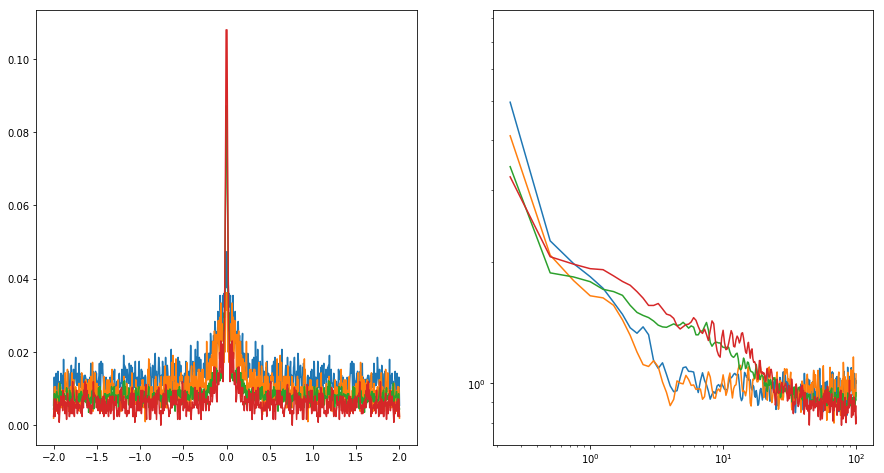

In [643]:
psd_win = np.abs(np.fft.fft(ac_all*signal.hann(ac_all.shape[-1])[None,None,:]))
psd = np.abs(np.fft.fft(ac_all))
cell= 44
print(max(f_ac))
plt.figure(figsize=(15,8))
plt.subplot(1,2,1)
plt.plot(t_ac[t_ac!=0],ac_all[:,cell,t_ac!=0].T)
plt.subplot(1,2,2)
#plt.loglog(f_ac, psd[:,cell,:].T, '-')
plt.loglog(f_ac, psd_win[:,cell,:].T, '-')

In [228]:
spks = np.sort(ephys_data['spiketrain'])
spks.max()*1000
# this is too goddamn slow
spks = np.sort(ephys_data['spiketrain'])
t_ac, ac = acf_events(spks, t_max, dt)
f_ac = np.fft.fftfreq(len(ac), dt)
psd = np.abs(np.fft.fft(ac))**2
ac[t_ac==0]=0
plt.subplot(1,2,1)
plt.plot(t_ac,ac)
plt.subplot(1,2,2)
plt.loglog(f_ac[1:400], psd[1:400])

KeyboardInterrupt: 

In [4]:
# compute PSDs
psd_path = result_basepath + rec_dirs[cur_rec] + '/psd/'

# get some params
nchan,nsamp = ephys_data['lfp'].shape
fs = ephys_data['fs']
ephys_data['t_lfp'] = np.arange(0,nsamp)/fs
elec_region = np.unique(ephys_data['elec_regions'])[0]

# get subset of behavior that marks wake and sleep
behav_sub = behav_data[behav_data['Label'].isin(['Wake', 'Sleep'])]

# name, nperseg, noverlap, f_range, outlier_pct
p_configs = [['1sec', int(fs), int(fs/2), [0., 200.], 5],
                ['5sec', int(fs*5), int(fs*4), [0., 200.], 5]]

for p_cfg in p_configs:
    # parameter def
    print(p_cfg)
    saveout_path = psd_path+ p_cfg[0]
    nperseg, noverlap, f_range, outlier_pct = p_cfg[1:]
    
    psd_mean, psd_med,  = [], []
    for ind, cur_eps in behav_sub.iterrows():
        # find indices of LFP that correspond to behavior
        lfp_inds = np.where(np.logical_and(ephys_data['t_lfp']>=cur_eps['Start'],ephys_data['t_lfp']<cur_eps['End']))[0]    

        # compute mean and median welchPSD
        p_squished = spectral.compute_spectrum(ephys_data['lfp'][:,lfp_inds], ephys_data['fs'], method='welch',avg_type='mean', nperseg=nperseg, noverlap=noverlap, f_range=f_range, outlier_pct=outlier_pct)
        f_axis, cur_psd_mean = p_squished[0,:], p_squished[1::2,:] # work-around for ndsp currently squishing together the outputs
        p_squished = spectral.compute_spectrum(ephys_data['lfp'][:,lfp_inds], ephys_data['fs'], method='welch',avg_type='median', nperseg=nperseg, noverlap=noverlap, f_range=f_range, outlier_pct=outlier_pct)
        f_axis, cur_psd_med = p_squished[0,:], p_squished[1::2,:]

        # append to list
        psd_mean.append(cur_psd_mean)
        psd_med.append(cur_psd_med)    

    # collect, stack, and save out
    psd_mean, psd_med, behav_info = np.array(psd_mean),np.array(psd_med),np.array(behav_sub)
    save_dict = dict((name,eval(name)) for name in ['f_axis','psd_mean', 'psd_med','nperseg','noverlap','fs','outlier_pct', 'behav_info', 'elec_region'])
    utils.makedir(saveout_path, timestamp=False)
    np.savez(file=saveout_path+'/psds.npz', **save_dict)


['1sec', 1250, 625, [0.0, 200.0], 5]
/Users/rdgao/Documents/code/research/field-echos/results/fcx1/wakesleep/20140526_277um/psd/1sec/
['5sec', 6250, 5000, [0.0, 200.0], 5]
/Users/rdgao/Documents/code/research/field-echos/results/fcx1/wakesleep/20140526_277um/psd/5sec/


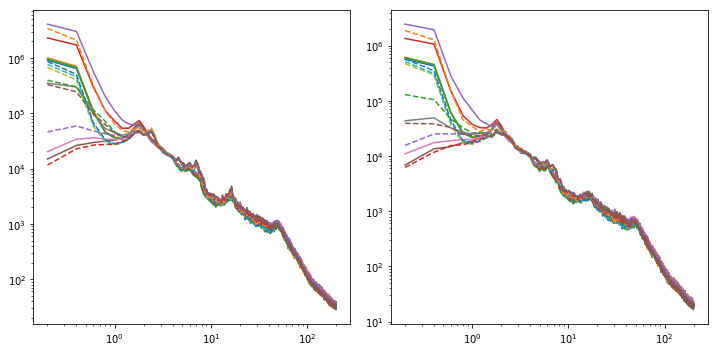

In [158]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.loglog(f_axis, psd_mean[0].T)
plt.loglog(f_axis, psd_mean[1].T,'--')

plt.subplot(1,3,2)
plt.loglog(f_axis, psd_med[0].T)
plt.loglog(f_axis, psd_med[1].T,'--')

plt.tight_layout()

In [218]:
fooof_settings = [['knee', 4, (0.1,200)],
         ['fixed', 4, (0.1,200)],
         ['fixed', 2, (0.1,10)],
         ['fixed', 2, (30,55)]]

for psd_win in ['1sec/', '5sec/']:
    psd_folder = psd_path+psd_win
    psd_data = np.load(psd_folder+'psd.npz')
    for psd_mode in ['psd_mean', 'psd_med']:
        for f_s in fooof_settings:
            fg = FOOOFGroup(aperiodic_mode=f_s[0], max_n_peaks=f_s[1])
            fgs = fit_fooof_group_3d(fg, psd_data['f_axis'], psd_data[psd_mode], freq_range=f_s[2])
            fg_all = combine_fooofs(fgs)                
            fooof_savepath = utils.makedir(psd_folder, '/fooof/'+psd_mode+'/', timestamp=False)
            fg.save('fg_%s_%ipks_%i-%iHz'%(f_s[0],f_s[1],f_s[2][0],f_s[2][1]), fooof_savepath, save_results=True, save_settings=True)

Running FOOOFGroup across 8 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 8 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 8 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower

Running FOOOFGroup across 8 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 8 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 8 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower

Running FOOOFGroup across 32 power spectra.
                                                                                                  
                                       FOOOF - GROUP RESULTS                                      
                                                                                                  
                             Number of power spectra in the Group: 32                             
                                                                                                  
                       The model was run on the frequency range 30 - 55 Hz                        
                                 Frequency Resolution is 0.20 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                                                                 

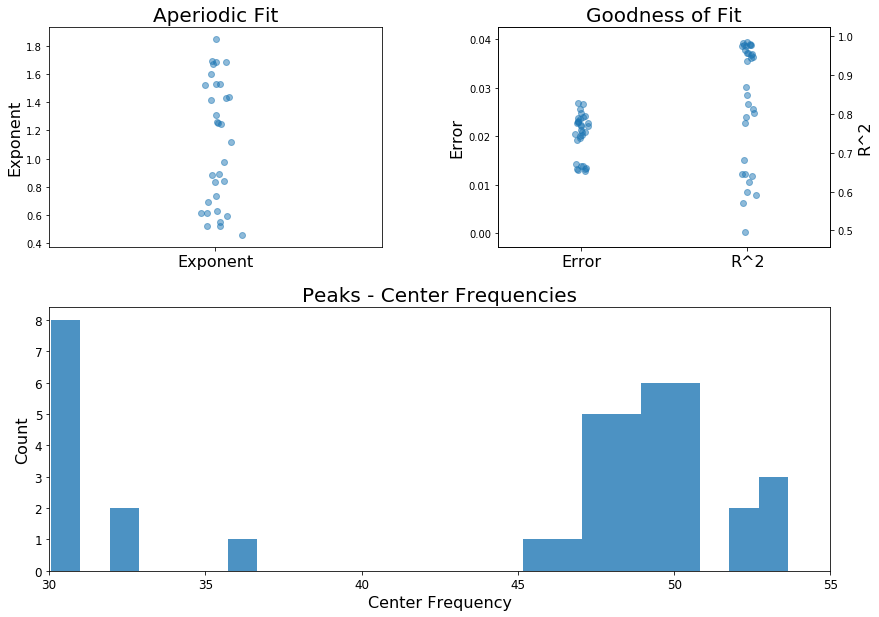

In [216]:
#fgs = fit_fooof_group_3d(fg, psd_data['f_axis'], psd_data[psd_mode], freq_range=f_s[2])
fg_all = combine_fooofs(fgs)
fg_all.report()

In [ ]:
cur_rec=0
data = io.loadmat(basepath+rec_dirs[cur_rec]+'/'+rec_dirs[cur_rec]+'_combined.mat', squeeze_me=True)
pd.DataFrame(data['spike_info'], columns=data['spike_info_cols'])

In [39]:
basepath = '/Users/rdgao/Documents/data/MNI_rest/'
datafile = basepath + 'WakefulnessMatlabFile.mat'
data_dict = io.loadmat(datafile, squeeze_me = True)
result_basepath = '/Users/rdgao/Documents/code/research/field-echos/results/MNI_rest/'

In [40]:
print(data_dict.keys())
fs = data_dict['SamplingFrequency']
data = data_dict['Data']
sig_len, nchans = data.shape

dict_keys(['__header__', '__version__', '__globals__', 'AgeAtTimeOfStudy', 'ChannelName', 'ChannelPosition', 'ChannelRegion', 'ChannelType', 'Data', 'FacesLeft', 'FacesRight', 'Gender', 'Hemisphere', 'NodesLeft', 'NodesLeftInflated', 'NodesRegionLeft', 'NodesRegionRight', 'NodesRight', 'NodesRightInflated', 'Patient', 'RegionName', 'SamplingFrequency'])


In [41]:
def compute_spectrum_w_holes(data, fs, window, nperseg, noverlap):
    f_axis,t_axis,spg = signal.spectrogram(data, fs, 'hann', nperseg, noverlap)
    psd_mean = spg[:,~np.all(spg==0, axis=0)].mean(1)
    psd_median = np.median(spg[:,~np.all(spg==0, axis=0)],axis=1)
    return f_axis, psd_mean, psd_median

def compute_psds_whole(data, fs, nperseg, noverlap):
    # compute psd and toss slices with holes
    psd_mean = np.zeros((int(nperseg/2+1), nchans))
    psd_med = np.zeros((int(nperseg/2+1), nchans))
    for chan in range(nchans):
        f_axis, psd_mean[:,chan], psd_med[:,chan] = compute_spectrum_w_holes(data[:,chan], fs, 'hann', nperseg, noverlap)
    return f_axis, psd_mean, psd_med

# Compute PSDs
#### 1s window (1Hz)

In [5]:
nperseg, noverlap = int(fs), int(fs/2)
f_axis, psd_mean, psd_med = compute_psds_whole(data, fs, nperseg, noverlap)
saveout_path = utils.makedir(result_basepath, 'psd/1sec/', timestamp=False)
np.savez(saveout_path+'psds.npz', psd_mean=psd_mean, psd_med=psd_med,
         f_axis=f_axis, nperseg=nperseg, noverlap=noverlap)

#### 5s window (0.2Hz)

In [7]:
nperseg, noverlap = int(fs*5), int(fs*4)
f_axis, psd_mean, psd_med = compute_psds_whole(data, fs, nperseg, noverlap)
saveout_path = utils.makedir(result_basepath, '/psd/5sec/', timestamp=False)
np.savez(saveout_path+'psds.npz', psd_mean=psd_mean, psd_med=psd_med,
         f_axis=f_axis, nperseg=nperseg, noverlap=noverlap)

# FOOOFing

In [30]:
fooof_settings = [['knee', 2, (2,55)],
                 ['fixed', 2, (2,55)],
                 ['fixed', 1, (1,10)],
                 ['fixed', 1, (30,55)]]

for psd_win in ['1sec/', '5sec/']:
    psd_folder = result_basepath+'/psd/'+psd_win
    psd_data = np.load(psd_folder+'psds.npz')
    for f_s in fooof_settings:
        fg = FOOOFGroup(background_mode=f_s[0], max_n_peaks=f_s[1])
        fg.fit(psd_data['f_axis'], psd_data['psd_mean'].T, freq_range=f_s[2])
        fooof_savepath = utils.makedir(psd_folder, '/fooof/', timestamp=False)
        fg.save('fg_%s_%ipks_%i-%iHz'%(f_s[0],f_s[1],f_s[2][0],f_s[2][1]), fooof_savepath, save_results=True, save_settings=True)

Running FOOOFGroup across 1772 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1772 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

Running FOOOFGroup across 1772 power spectra.

FOOOF WARNING: Lower-bound peak width limit is < or ~= the frequency resolution: 1.00 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too 

In [371]:
def my_fftfreqs(sig_len, fs):
    # num_k is the total (or max) wavenumber/ number of frequencies
    #   for every point in your signal, you have a wavenumber
    num_k = sig_len
    
    # positive frequencies are easy, it goes from 0 to nyquist at even spacing
    # this means that you might not actually land on f_nyquist
    pos_f = np.arange(0,fs/2,fs/num_k)
    if num_k%2:
        # num_k is odd, negative frequencies are symmetric about 0Hz
        neg_f = -pos_f[1:][::-1]
    else:
        # if num_k is even, negative frequencies are symmetric about 0Hz, plus Nyquist
        #   we take the negative of Nyquist freq to follow numpy convention
        neg_f = np.concatenate(([-fs/2], -pos_f[1:][::-1]))
    return np.concatenate((pos_f, neg_f))

def my_sft(t, sig, fs):
    # SFT stands for slow Fourier transform. Get it?
    f_axis = my_fftfreqs(len(sig), fs)
    
    # the holder array has to be initialized as complex
    SFT = np.zeros(len(sig))*1j
    for i, f in enumerate(f_axis):
        # where the magic happens
        cosine, sine = np.cos(t*2*np.pi*f), np.sin(t*2*np.pi*f)
        SFT[i] = np.dot(sig,cosine)+np.dot(sig,sine)*1.j
    
    return f_axis, SFT    

In [ ]:
# little blurb to deal with one particularly big datafile
cur_rec = 22
# load the datafile which did not save the LFP
ephys_data = io.loadmat(basepath+rec_dirs[cur_rec]+'/'+rec_dirs[cur_rec]+'_ephys.mat', squeeze_me=True)

# load the datafile that did save the LFP in hdf5 form (MAT -v7.3)
import numpy as np, h5py 
f = h5py.File(basepath+rec_dirs[cur_rec]+'/'+rec_dirs[cur_rec]+'_ephys2.mat','r')
ephys_data['lfp'] = np.array(f['lfp'].value).T

# re-save
io.savemat(basepath+rec_dirs[cur_rec]+'/'+rec_dirs[cur_rec]+'_ephys.mat', ephys_data, do_compression=True)